In [1]:
import pandas as pd
import numpy as np
import re
import gsw
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cmocean.cm as cm

In [2]:
plt.rcParams.update({'font.size': 16}) 

This script interpolates CTD and bottle file data. The lateral density gradient is computed from interpolated potential density. The interpolation is also used to generate panels for figure 2, and for supplementary figures 1 and 2

In [3]:
source_dir = '../../data_directory/ctd_and_water_column/'
metadata_dir = '../../data_directory/metadata/'
bathy_dir = '../../data_directory/mean_sections/interpolated_sensor_data/'
mean_sections_dir = '../../data_directory/mean_sections/'

In [4]:
# Interpolation Parameters
xinterval = 5.0  # km
yinterval = 1.0  # dbar ~ meter
# yinterval = 2.0  # dbar ~ meter

In [5]:
# Load data
ctd = pd.read_csv(source_dir + 'final_qc_CTD_data.csv')

trap_metadata = pd.read_csv(metadata_dir + 'trap_metadata.csv')

In [6]:
bottle = pd.read_csv(source_dir + 'final_qc_bottle_file.csv')

## Trim Down Bottle File to Relevant Columns - prep for joining to CTD data

# For Joining, must have a CTDPRS_DBAR column that is rounded to nearest full meter
bottle['CTDPRS_DBAR'] = bottle['CTDPRS_DBAR_BOTTLE'].round()

# -999.0 is code for NAN in Gert's convention
bottle.replace(-999.0, np.nan, inplace=True)

## Duplicate (identical) bottles fired at same depth cause problems later on for interpolation, dropping one (other sample is 973)
bottle = bottle.drop(bottle[bottle['SAMPNO'] == 972].index)

## Only need limited columns from this bottle file. First row is sample identifying columns
## NOTE: there are many columns i am typing out, then commenting. We dont need these right now, but might later
bottle = bottle[['SAMPNO', 'BTLNBR', 'BTLNBR_FLAG_W',
                 # Join Columns to link these data to CTD data
                 'SECT_ID', 'STNNBR', 'CASTNO', 'CTDPRS_DBAR', 'CTDPRS_DBAR_BOTTLE',
                 # Other Join Columns
                 'SECTION', 'LINE',
                 # Bottle Chlorophyll
                 'CHLORA_UG/L', 'CHLORA_FLAG_W', 'CHLORA_STDEV_UG/L', 'CHLORA_STDEV_FLAG_W', 'CHLORA_CV_%', 'CHLORA_CV_FLAG_W']]

In [7]:
ctd_with_bottle = pd.merge(ctd, bottle)

In [8]:
## Set up Bathymetry
hr_bathy = pd.read_csv(bathy_dir + 'hr_bathymetry.csv')
hr_bathy['dist_along_transect_km'] = hr_bathy['dist_along_transect_km'].max() - hr_bathy['dist_along_transect_km']


hre_bathy = pd.read_csv(bathy_dir + 'hre_bathymetry.csv')
hre_bathy['dist_along_transect_km'] = hre_bathy['dist_along_transect_km'].max() - hre_bathy['dist_along_transect_km']

In [9]:
## Trap Data
traps = trap_metadata[['Sample_Number', 'Deploy_Station', 'Trap_Depth']].copy()

traps['STNNBR'] = traps['Deploy_Station'].dropna().astype(int)
traps['CTDPRS_DBAR'] = traps['Trap_Depth'].round().astype(int)

traps = traps.rename(columns={
    'Sample_Number': 'trap',
    'section': 'transect'
})
traps.head()

,trap,Deploy_Station,Trap_Depth,STNNBR,CTDPRS_DBAR
0,T001S,15,1,15,1
1,T001D,15,20,15,20
2,T002S,16,15,16,15
3,T002D,16,30,16,30
4,T003S,21,3,21,3


In [10]:
# Sections you want to loop through
sections = ['HR1', 'HR2', 'HR3', 'HR4', 'HR5', 'HR6', 'HR7', 'HR8',
            'HRE1', 'HRE2', 'HRE3', 'HRE4', 'HRE5', 'HRE6', 'HRE7']

# panel_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
#                 'A', 'B', 'C', 'D', 'E', 'F', 'G']
panel_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
                'a', 'b', 'c', 'd', 'e', 'f', 'g']

# Store output
all_grads = []
interpolated_surfaces = []


# for section in sections:
for i in range(len(sections)):
    section = sections[i]
    panel_label = panel_labels[i]

    print(f'Processing {section}')

    # 1. Subset and sort
    sec = ctd[(ctd['SECTION'] == section) & (ctd['CASTNO'] == 1)].copy()
    sec = sec.sort_values(by=['LATITUDE', 'CTDPRS_DBAR']).dropna(subset=['SIGMA0_kgperm3'])

    # 2. Compute distance along transect
    distance = sec[['STNNBR', 'LATITUDE', 'LONGITUDE']].drop_duplicates().sort_values(by='LATITUDE')
    distance['dx_km'] = np.insert(gsw.distance(distance['LONGITUDE'], distance['LATITUDE']) / 1000, 0, np.nan)
    distance['dist_km'] = distance['dx_km'].fillna(0).cumsum()
    sec = sec.merge(distance[['STNNBR', 'dist_km']], on='STNNBR')

    # 3. Interpolate SIGMA0 onto grid
    x = sec['dist_km'].values
    y = sec['CTDPRS_DBAR'].values
    z = sec['SIGMA0_kgperm3'].values

    x_grid = np.arange(x.min(), x.max() + xinterval, xinterval)
    y_grid = np.arange(y.min(), y.max() + 5 * yinterval, yinterval)
    x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

    z_grid_linear = griddata((x, y), z, (x_mesh, y_mesh), method='cubic') #method='linear')
    z_grid_nearest = griddata((x, y), z, (x_mesh, y_mesh), method='nearest') # fill out the edges

    # Fill NaNs in linear with nearest
    z_grid = np.where(np.isnan(z_grid_linear), z_grid_nearest, z_grid_linear)

    # 4. Compute lateral gradient (density only)
    dz_dx = np.gradient(z_grid, xinterval, axis=1)  # kg/m^4
    
    # 5. Interpolate gradient back to original cast positions
    grad_at_casts = griddata((x_mesh.ravel(), y_mesh.ravel()),
                                dz_dx.ravel(),
                                (x, y),
                                method='linear')

    sec['LateralDensityGrad'] = grad_at_casts
    all_grads.append(sec)

    ## Interpolate Chlorophyll onto similar grid
    # 1. Subset and sort
    sec1 = ctd_with_bottle[(ctd_with_bottle['SECTION'] == section) & (ctd_with_bottle['CASTNO'] == 1)].copy()
    # sec1 = sec1.sort_values(by=['LATITUDE', 'CTDPRS_DBAR']).dropna(subset=['SIGMA0_kgperm3'])
    sec1 = sec1.sort_values(by=['LATITUDE', 'CTDPRS_DBAR']).dropna(subset=['CHLORA_UG/L'])

    # Use 
    sec1 = sec1.merge(distance[['STNNBR', 'dist_km']], on='STNNBR')
    sec1 = sec1.dropna(subset=['CHLORA_UG/L'])
    x1 = sec1['dist_km'].values
    y1 = sec1['CTDPRS_DBAR'].values
    z1 = sec1['CHLORA_UG/L'].values

    x1_grid = np.arange(x1.min(), x1.max() + xinterval, xinterval)
    y1_grid = np.arange(y1.min(), y1.max() + 5 * yinterval, yinterval)
    x1_mesh, y1_mesh = np.meshgrid(x1_grid, y1_grid)

    z1_grid_linear = griddata((x1, y1), z1, (x1_mesh, y1_mesh), method='cubic') #method='linear')
    z1_grid_nearest = griddata((x1, y1), z1, (x1_mesh, y1_mesh), method='nearest') # fill out the edges

    # Fill NaNs in linear with nearest
    z1_grid = np.where(np.isnan(z1_grid_linear), z1_grid_nearest, z1_grid_linear)
    # Blank correction can result in small negative values, set these to zero
    z1_grid = np.clip(z1_grid, 0, None)   # Only lower bound; None means no upper bound
    # z1_grid = z1_grid_linear  # leave NaNs as NaNs for chlorophyll

    ## Save interpolated surface for later use
    physics_df = pd.DataFrame({
        'SECTION': section,
        'distance_km': x_mesh.ravel(),
        'pressure_dbar': y_mesh.ravel(),
        'sigma0_kgperm3': z_grid.ravel(),
        'density_gradient': dz_dx.ravel()
    })
    bio_df = pd.DataFrame({
        'SECTION': section,
        'distance_km': x1_mesh.ravel(),
        'pressure_dbar': y1_mesh.ravel(),
        'chlora_ug/l': z1_grid.ravel()
    })
    surf_df = pd.merge(physics_df, bio_df, on=['SECTION', 'distance_km', 'pressure_dbar'], how='outer')
    interpolated_surfaces.append(surf_df)

    # 6. Plotting
    # Select Bathymetry
    if section.startswith('HRE'):
        bathy = hre_bathy
    else:
        bathy = hr_bathy

    # plt.figure(figsize=(10, 8))
    plt.figure(figsize=(7, 6))

    # Filled contour: Lateral density gradient
    cs = plt.contourf(x_mesh, y_mesh, dz_dx,
                        cmap=cm.balance, levels=100,
                        vmin=-0.15, vmax=0.15)
                        # vmin = -0.025, vmax = 0.025, extend='both')

    # Red dashed contour line at gradient = 0.02
    cgrad = plt.contour(x_mesh, y_mesh, dz_dx,
                        levels=[0.02],
                        colors='red',
                        linewidths=1.5,
                        linestyles='--')
    plt.clabel(cgrad, fmt={0.02: '0.02'}, inline=True, fontsize=8)

    cgrad2 = plt.contour(x_mesh, y_mesh, dz_dx,
                        levels=[0.01],
                        colors='green',
                        linewidths=1.5,
                        linestyles='--')
    plt.clabel(cgrad2, fmt={0.01: '0.01'}, inline=True, fontsize=8)

    # Sigma0 contours (optional)
    try:
        pd_levels = np.arange(np.nanmin(z_grid), np.nanmax(z_grid), 0.25)
        cp = plt.contour(x_mesh, y_mesh, z_grid,
                            levels=pd_levels,
                            colors='black',
                            linewidths=0.5)
        plt.clabel(cp, inline=True, fontsize=12, fmt='%.1f')
    except Exception as e:
        print(f"Skipping sigma0 contours for {section}: {e}")

    # Scatter: original CTD cast positions
    # plt.scatter(x, y, c=grad_at_casts, cmap=cm.balance,
    #             edgecolor='k', vmin=-0.15, vmax=0.15, s=10)
    plt.scatter(x, y, c = 'gray', s=2.5)

    # Trap Positions with Labels
    stations_in_section = sec['STNNBR'].unique()

    if 'traps' in locals() or 'traps' in globals():
        # Subset traps for this section
        # traps_sec = traps[traps['transect'] == section]
        traps_sec = traps[traps['STNNBR'].isin(stations_in_section)].copy()
        traps_sec = pd.merge(traps_sec, distance[['STNNBR', 'dist_km']], on='STNNBR', how='left')
        for _, row in traps_sec.iterrows():
            plt.plot(row['dist_km'], row['CTDPRS_DBAR'], markersize=6, marker='o', color='k')
            plt.text(row['dist_km'], row['CTDPRS_DBAR'], str(row['trap']),
                        fontsize=12, ha='right', va='center', color='k') #, fontweight='bold')
            
    # Bathymetry Polygon
    bathy_polygon = Polygon(bathy, closed=True, color = 'gray', zorder=3)
    plt.gca().add_patch(bathy_polygon)
    plt.ylim(0, 50)

    # === Plot formatting ===
    plt.gca().text(0.02, 0.98, panel_label,
        transform=plt.gca().transAxes,  # axes fraction coordinates
        fontsize=20,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    # plt.colorbar(cs, label='Lateral Density Gradient (kg/m⁴)')
    plt.xlabel('Distance Along Transect (km)')
    plt.ylabel('Pressure (dbar)')
    # plt.title(f'{section} Lateral Density Gradient (kg/m⁴)')
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'../plot/{section}.png', dpi = 600, bbox_inches='tight')
    plt.close()


# Combine all sections
# all_grads_df = pd.concat(all_grads)
all_grads_df = pd.concat(all_grads)[['SECTION', 'STNNBR', 'CASTNO', 'CTDPRS_DBAR', 'LateralDensityGrad', 'dist_km']]

# Merge with original CTD dataframe to preserve stations that are not on primary transects
ctd_with_gradient = pd.merge(ctd, all_grads_df,
                             how='left',  # keep all rows from original ctd
                             on=['SECTION', 'STNNBR', 'CASTNO', 'CTDPRS_DBAR'])

# Save output
ctd_with_gradient.to_csv(source_dir + 'final_qc_CTD_data_interpolatedGrad.csv', index=False)


Processing HR1
Processing HR2
Processing HR3
Processing HR4
Processing HR5
Processing HR6
Processing HR7
Processing HR8
Processing HRE1
Processing HRE2
Processing HRE3
Processing HRE4
Processing HRE5
Processing HRE6
Processing HRE7


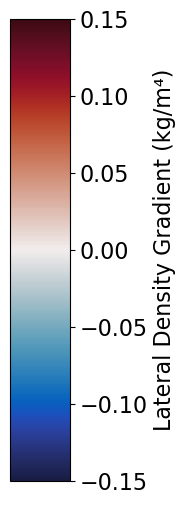

In [11]:
## Plot Colobar Separately
import matplotlib as mpl

# Use the same colormap and limits as your main plot
cmap = cm.balance
norm = mpl.colors.Normalize(vmin=-0.15, vmax=0.15)

fig, ax = plt.subplots(figsize=(2, 6))  # size as desired (narrow and tall for vertical bar)
fig.subplots_adjust(left=0.5, right=0.8) # Center the bar nicely

cbar = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
cbar.set_label('Lateral Density Gradient (kg/m⁴)')

plt.savefig('../plot/colorbar_density_gradient.png', dpi=600, bbox_inches='tight', transparent=True)
plt.show()
plt.close()

In [12]:
hr_surfs = [df for df in interpolated_surfaces if re.match(r'HR\d', df['SECTION'].iloc[0])]
hre_surfs = [df for df in interpolated_surfaces if re.match(r'HRE\d', df['SECTION'].iloc[0])]

In [13]:
hr_mean = pd.concat(hr_surfs).groupby(['distance_km', 'pressure_dbar'], as_index=False).mean()
hre_mean = pd.concat(hre_surfs).groupby(['distance_km', 'pressure_dbar'], as_index=False).mean()

/var/folders/8g/k7dpf2yx1v31sdbm639f5tc00000gn/T/ipykernel_46342/1455156464.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hr_mean = pd.concat(hr_surfs).groupby(['distance_km', 'pressure_dbar'], as_index=False).mean()
/var/folders/8g/k7dpf2yx1v31sdbm639f5tc00000gn/T/ipykernel_46342/1455156464.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hre_mean = pd.concat(hre_surfs).groupby(['distance_km', 'pressure_dbar'], as_index=False).mean()


In [14]:
hr_meanChl = hr_mean.pivot(index='pressure_dbar', columns='distance_km', values='chlora_ug/l')
hre_meanChl = hre_mean.pivot(index='pressure_dbar', columns='distance_km', values='chlora_ug/l')
hr_meanSigma = hr_mean.pivot(index='pressure_dbar', columns='distance_km', values='sigma0_kgperm3')
hre_meanSigma = hre_mean.pivot(index='pressure_dbar', columns='distance_km', values='sigma0_kgperm3')
hr_meanGrad = hr_mean.pivot(index='pressure_dbar', columns='distance_km', values='density_gradient') * 1000  # convert to 10*kg/m4 for plotting
hre_meanGrad = hre_mean.pivot(index='pressure_dbar', columns='distance_km', values='density_gradient') * 1000  # convert to 10*kg/m4 for plotting

In [15]:
## These files are specifically for fig2
hr_meanChl.to_csv(mean_sections_dir + 'bottle_chl_mean_section_hr.csv')
hre_meanChl.to_csv(mean_sections_dir + 'bottle_chl_mean_section_hre.csv')